### Import data set from Kaggle

In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/hsankesara/flickr-image-dataset/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jakobbruchhausen
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.16G/8.16G [05:16<00:00, 27.7MB/s]


### Import dependancies

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch import nn
import matplotlib.pyplot as plt
import torch
from itertools import chain
from PIL import Image

### Data loading and handling

In [4]:
all_img_path = Path.cwd() / "flickr-image-dataset/flickr30k_images"
all_img_filenames = list(all_img_path.glob("*.jpg"))
train_filenames, testval_filenames = train_test_split(all_img_filenames, test_size=0.2, random_state=1)
val_filenames, test_filenames = train_test_split(testval_filenames, test_size=0.5, random_state=1)

subdirectories = {"train": train_filenames,
                  "val": val_filenames,
                  "test": test_filenames,
                 }

for subdirectory in subdirectories.keys():
    subdirectory = Path(subdirectory)
    subdirectory.mkdir(parents=True, exist_ok=True)
    
def fill_sub_dir(sub_dir, file_subset):
    
    for file in file_subset:
        file_path = Path.cwd() / sub_dir / file.name
        shutil.copyfile(file, file_path)
        
for sub_dir, file_subset in subdirectories.items():
    fill_sub_dir(sub_dir, file_subset)

In [45]:
class ImgData(Dataset):
    
    def __init__(self, root, transform_grayscale, transform_color):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform_grayscale = transform_grayscale
        self.transform_color = transform_color
        
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_imgs_sub_dir(self.root)
            
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path = self._samples[index]
        # Load the image into memory
        gray_img = Image.open(path)
        c_img = Image.open(path)
        
        # Perform transforms, if any.
        if self.transform_grayscale is not None:
            gray_img = self.transform_grayscale(gray_img)
            
        if self.transform_color is not None:
            c_img = self.transform_color(c_img)
            
        return gray_img, c_img
    
    def __len__(self):
        """Total number of samples"""
        return len(self._samples)
    
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return list(sub_dir.glob("*.jpg"))
    
example_dataset = ImgData("./train", transform_grayscale=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                             transforms.ToTensor()]), 
                          transform_color=transforms.ToTensor())

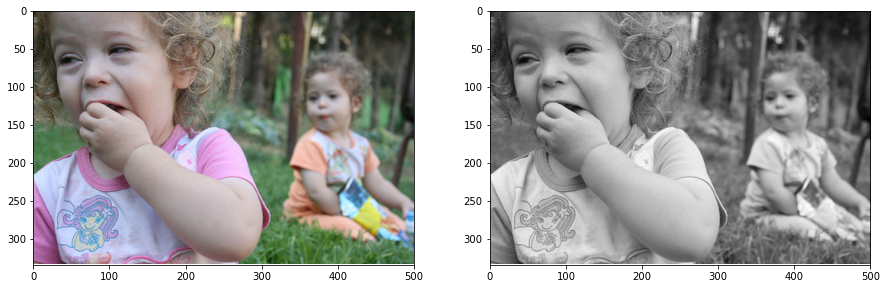

In [46]:
def display_image(axis1, axis2, image_1, image_2):
    """Display a tensor as an image
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    if not isinstance(image_1, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")

    image_data_1 = image_1.permute(1, 2, 0).detach().cpu().numpy()
    image_data_2 = image_2.permute(1, 2, 0).detach().cpu().numpy()
    height1, width1, _ = image_data_1.shape
    height2, width2, _ = image_data_2.shape

    if image_data_1.shape[2] == 1:
        axis1.imshow(image_data_1, cmap='gray')
    else:
        axis1.imshow(image_data_1)
        
    if image_data_2.shape[2] == 1:
        axis2.imshow(image_data_2, cmap='gray')
    else:
        axis2.imshow(image_data_2)
    
    axis1.set_xlim(0, width1)
    axis2.set_xlim(0, width2)
    axis1.set_ylim(height1, 0)
    axis2.set_ylim(height2, 0)


_, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
some_random_index = np.random.randint(25000)
some_random_index = 32
gray_image, color_image = example_dataset[some_random_index]
display_image(axis1, axis2, color_image, gray_image)




### Data pre-processing

In [47]:
# create greyscale data loaders for training, validataion and test data
img_size = 112
batch_size = 128
num_workers=0

transform_grayscale = transforms.Compose([transforms.Resize((img_size,img_size)) , 
                                transforms.Grayscale(num_output_channels=1), 
                                transforms.ToTensor()])
transform_color = transforms.Compose([transforms.Resize((img_size,img_size)), 
                                transforms.ToTensor()])

train_dataloader = DataLoader(ImgData("./train", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=num_workers)
val_dataloader = DataLoader(ImgData("./val", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=num_workers)
test_dataloader = DataLoader(ImgData("./test", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=num_workers)


### Creating the model

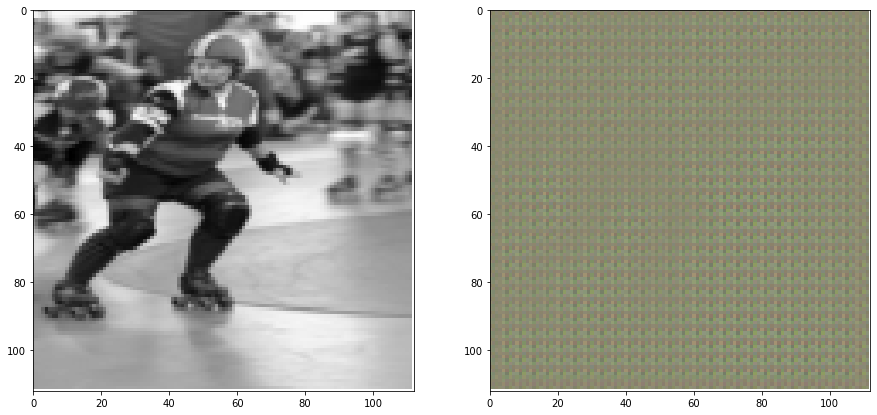

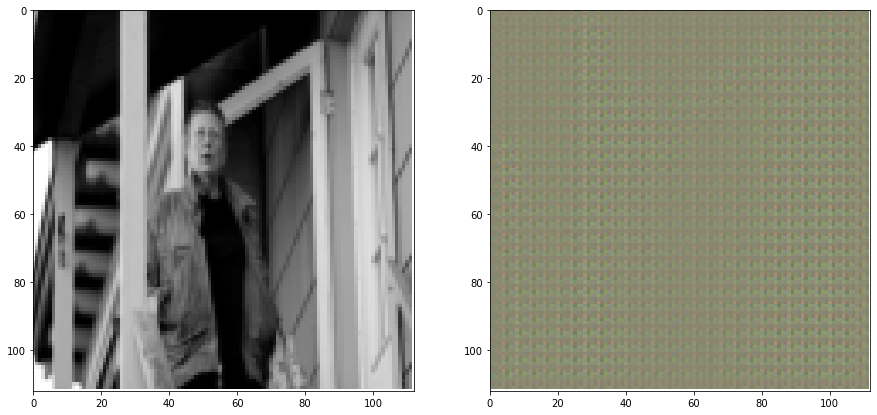

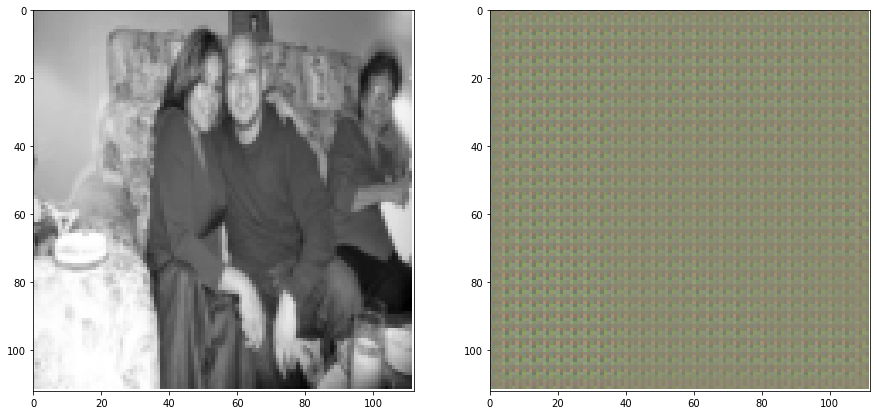

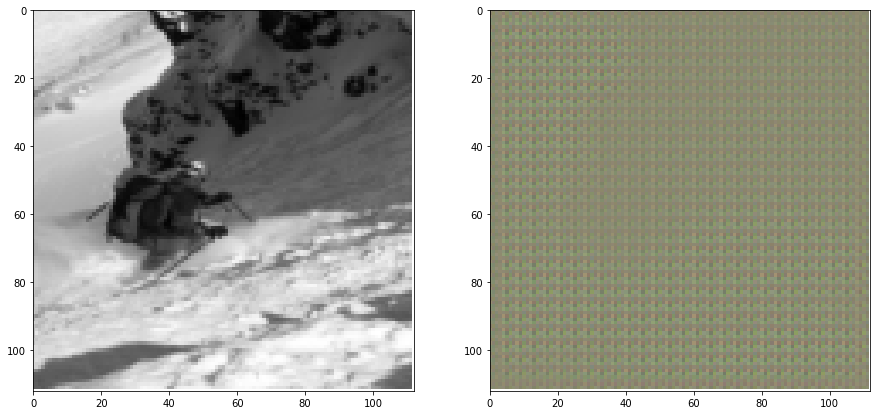

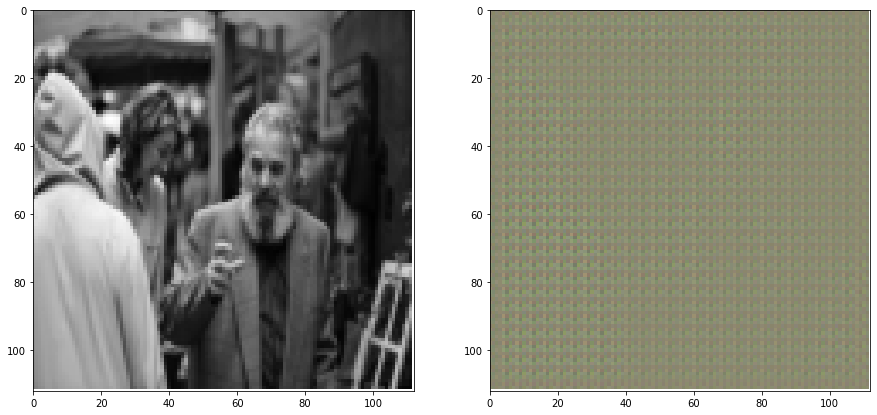

In [52]:
class ColorizationNetwork(nn.Module):
    def __init__(self):
        super(ColorizationNetwork, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, 2, stride=2, padding=0),
            nn.Conv2d(32, 64, 4, stride=2, padding=0),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0),
            nn.ConvTranspose2d(32, 3, 2, stride=2, padding=0)
        )
                
    def forward(self, input_batch):
        logits = self.conv_stack(input_batch)
        return torch.sigmoid(logits)

test_network = ColorizationNetwork()


for batch, (x,y) in enumerate(train_dataloader, 1):
    log = test_network.forward(x)
    for i in range(5):
        _, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
        display_image(axis1, axis2, x[i], log[i])
    break




### Defining training loop

In [56]:
def training(model, optimizer, loss_fn, batch_size, train_loader, val_loader, num_epocs, val_freq):
    print("---------------------------")
    print("---- Starting training ----")
    print("---------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_loss_list, val_loss_list = [], []
    train_t, val_t = [], []
    
    print("Validation...")
    model.eval()
    val_loss = validate(model, loss_fn, val_loader, device)
    val_loss_list.append(val_loss)
    val_t.append(0)
    
    # training over epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs}:")
        
        
        num_batches = len(train_loader)

        # iterating over all batches and training samples
        for batch, (x, y) in enumerate(train_loader, 1):
            
            print(f"Progress, batch {batch}/{num_batches}", end='\r')
            
            model.train()
            X, trueImg = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model.forward(X)
            loss = loss_fn(output, trueImg)
            loss.backward()
            optimizer.step()
            
            train_loss_list.append(loss.item())
            train_t.append(batch / num_batches + epoch)
            del X
            
                
            if val_freq is not None and batch % val_freq == 0:
                model.eval()
                print("Validation...")
                val_loss = validate(model, loss_fn, val_loader, device)
                model.train()
                val_loss_list.append(val_loss)
                val_t.append(batch / batch_size + epoch)
                
                print(f"Epoch {epoch}/{num_epochs}: \n"
                      f"Train loss: {sum(train_loss_list)/len(train_loss_list):.4f}, "
                      f"Val. loss: {val_loss:.4f}")
        print("\n")
        print("Validation...")
        model.eval()
        val_loss = validate(model, loss_fn, val_loader, device)
        val_loss_list.append(val_loss)
        val_t.append(epoch+1)     
                
        print(f"Epoch {epoch+1}/{num_epochs}: \n"
              f"Train loss: {sum(train_loss_list)/len(train_loss_list):.4f}, "
              f"Val. loss: {val_loss:.4f}") 
        
    print("---------------------------")
    print("----- Ending training -----")
    print("---------------------------")
                          
    return model, train_loss_list, val_loss_list, train_t, val_t

        
def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    num_valbatches = len(val_loader)
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader, 1):
            print(f"Evaluation in progress, batch: {batch}/{num_valbatches}", end='\r')
            X, trueImg = x.to(device), y.to(device)
            output = model.forward(X)
            
            batch_loss = loss_fn(output, trueImg)
            val_loss_cum += batch_loss.item()
        val_loss_cum /= len(val_loader)
        print("\n")
            
    return val_loss_cum

    

In [ ]:
net = ColorizationNetwork()

learning_rate = .01
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
num_epochs = 2

model, train_loss_list, val_loss_list, train_t, val_t = training(net,
                                                                 optimizer, 
                                                                 loss_fn, 
                                                                 batch_size, 
                                                                 train_dataloader, val_dataloader, 
                                                                 num_epochs, val_freq=None)

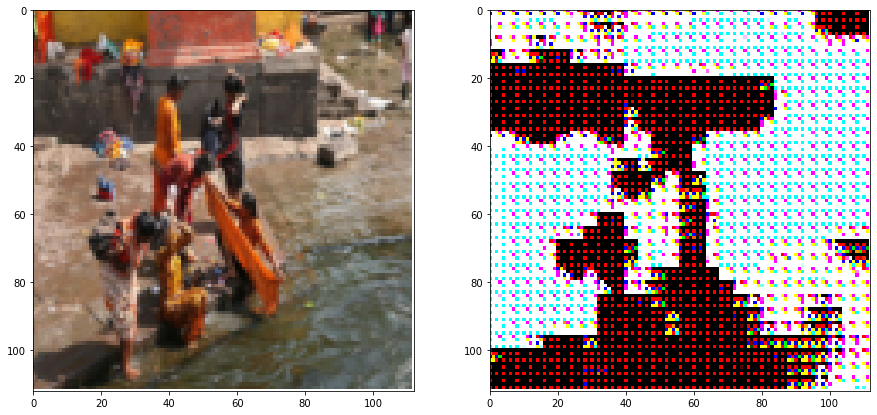

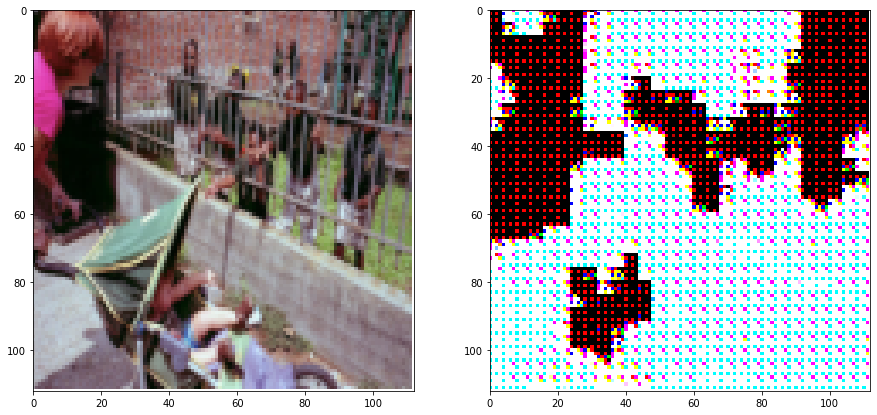

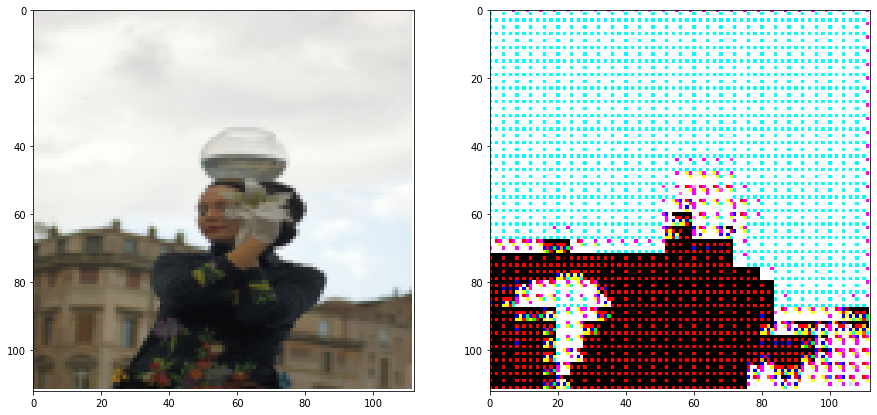

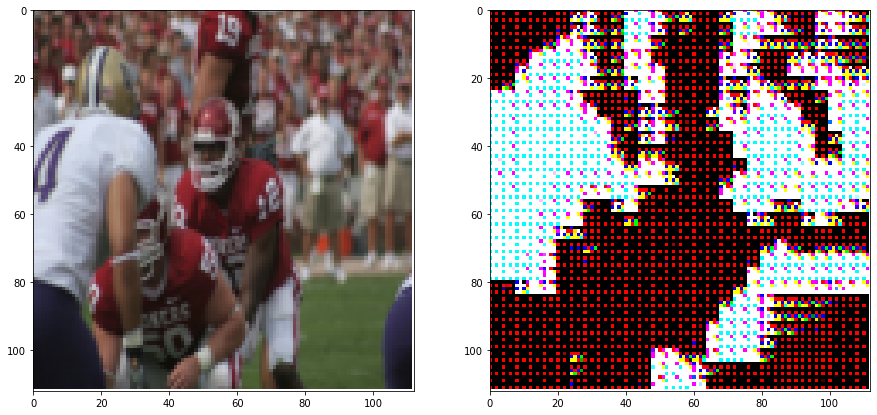

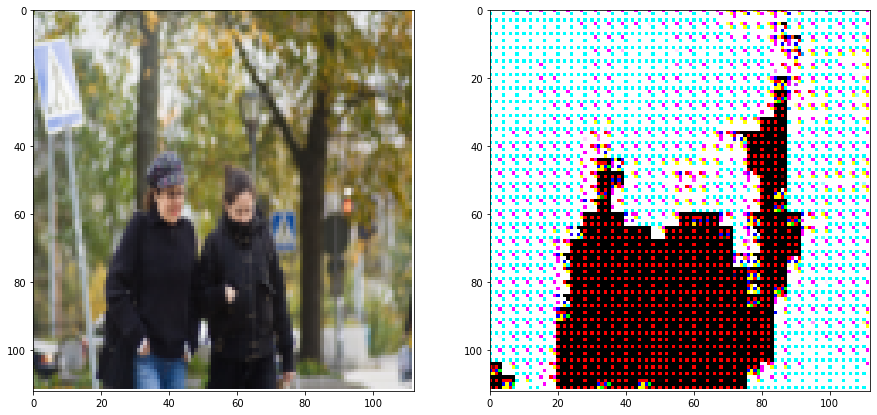

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for batch, (x,y) in enumerate(train_dataloader, 1):
    log = net.forward(x.to(device))
    for i in range(5):
        _, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
        display_image(axis1, axis2, y[i], log[i])
    break

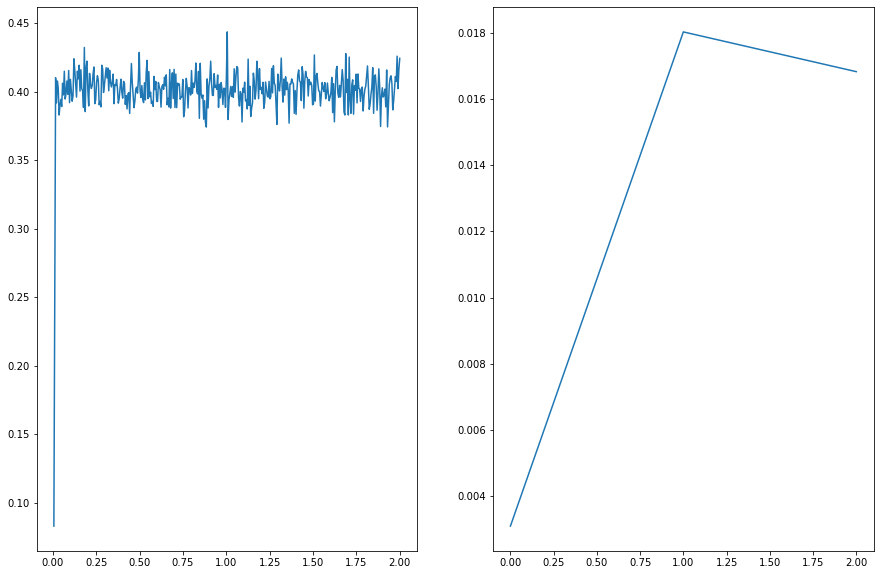

In [55]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.plot(train_t, train_loss_list)
ax2.plot(val_t, val_loss_list)
plt.show()


### Creating new network with feature fusion


In [63]:
class ColorizationNetwork(nn.Module):
    def __init__(self):
        super(ColorizationNetwork, self).__init__()
        self.low_level_net = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2),
            nn.Conv2d(64, 128, 3, stride=2),
            nn.Conv2d(128, 256)
        )
        
        self.global_features_net = nn.Sequential(
            nn.Conv2d()
        )
        
        self.colorization_net = nn.Sequential(
            nn.Conv2d(1, 32, 2, stride=2, padding=0),
            nn.Conv2d(32, 64, 4, stride=2, padding=0),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0),
            nn.ConvTranspose2d(32, 3, 2, stride=2, padding=0)
        )
                
    def forward(self, input_batch):
        logits = self.conv_stack(input_batch)
        return torch.sigmoid(logits)
    
updated_net = ColorizationNetwork()
print(updated_net.conv_stack)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2))
  (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
  (3): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
)
